In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os


In [3]:
print(os.listdir("/gdrive/My Drive/Retinal Imaging/Eyes"))

['Cataract', 'Normal', 'Diabetic Retinopathy', 'Glaucoma']


In [4]:
DATADIR = "/gdrive/My Drive/Retinal Imaging/Eyes"

CATEGORIES = ["Cataract","Diabetic Retinopathy","Glaucoma","Normal"]

In [5]:
IMG_SIZE = 50

In [6]:
all_data = []

def create_all_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                all_data.append([new_array, class_num])
            except Exception as e:
                pass

create_all_data()


In [7]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  4217


In [8]:
X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [10]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [11]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(2466, 50, 50, 3)
(1476, 50, 50, 3)
(275, 50, 50, 3)
(2466,)
(1476,)
(275,)


In [14]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

In [15]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=4)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=4)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=4)

In [16]:
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [18]:
res = tf.keras.applications.ResNet50V2(
    input_shape=(50, 50, 3),
    include_top = False
)

In [19]:
res_model = Sequential()
res_model.add(res)
res_model.add(Dropout(0.25))
res_model.add(MaxPooling2D())
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(4, activation='softmax'))

In [20]:
res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
history = res_model.fit(x_train, train_yCl,
                        batch_size=120,
                        epochs=10,
                        validation_data=(x_val, valid_yCl))

Epoch 1/10
21/21 [==============================] - 41s 346ms/step - loss: 1.2735 - accuracy: 0.5369 - val_loss: 46.9308 - val_accuracy: 0.2727
Epoch 2/10
21/21 [==============================] - 2s 104ms/step - loss: 0.6634 - accuracy: 0.7259 - val_loss: 5.6779 - val_accuracy: 0.5564
Epoch 3/10
21/21 [==============================] - 2s 103ms/step - loss: 0.4664 - accuracy: 0.8029 - val_loss: 5.6679 - val_accuracy: 0.6364
Epoch 4/10
21/21 [==============================] - 2s 107ms/step - loss: 0.3751 - accuracy: 0.8508 - val_loss: 11.0981 - val_accuracy: 0.5782
Epoch 5/10
21/21 [==============================] - 2s 109ms/step - loss: 0.2773 - accuracy: 0.8978 - val_loss: 3.4615 - val_accuracy: 0.7055
Epoch 6/10
21/21 [==============================] - 2s 119ms/step - loss: 0.2337 - accuracy: 0.9173 - val_loss: 3.6198 - val_accuracy: 0.7345
Epoch 7/10
21/21 [==============================] - 2s 109ms/step - loss: 0.1843 - accuracy: 0.9371 - val_loss: 3.6061 - val_accuracy: 0.6509
Epo

In [22]:
score_valid = res_model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_valid[1])

score_test = res_model.evaluate(x_test, test_yCl)
print("Test Accuracy: ", score_test[1])

score_train = res_model.evaluate(x_train, train_yCl)
print("Train Accuracy: ", score_train[1])

9/9 [==============================] - 3s 124ms/step - loss: 2.5032 - accuracy: 0.6982
Validation Accuracy:  0.6981818079948425
47/47 [==============================] - 2s 34ms/step - loss: 2.3979 - accuracy: 0.7202
Test Accuracy:  0.7201896905899048
78/78 [==============================] - 2s 21ms/step - loss: 1.7731 - accuracy: 0.7818
Train Accuracy:  0.7818329334259033


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Test verisi üzerinde tahminlerde bulunun
y_pred_probs = res_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Gerçek sınıfları alın
y_true_classes = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"F1-Score: {f1}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)


47/47 [==============================] - 5s 21ms/step
Accuracy: 0.7201897018970189
Precision: 0.7882739870170001
Recall: 0.7201897018970189
F1-Score: 0.7040625075604383
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.35      0.52       374
           1       0.99      0.98      0.99       395
           2       0.56      0.57      0.56       345
           3       0.58      0.96      0.72       362

    accuracy                           0.72      1476
   macro avg       0.78      0.72      0.70      1476
weighted avg       0.79      0.72      0.70      1476

Confusion Matrix:
[[131   0 138 105]
 [  0 388   3   4]
 [  2   1 195 147]
 [  0   1  12 349]]


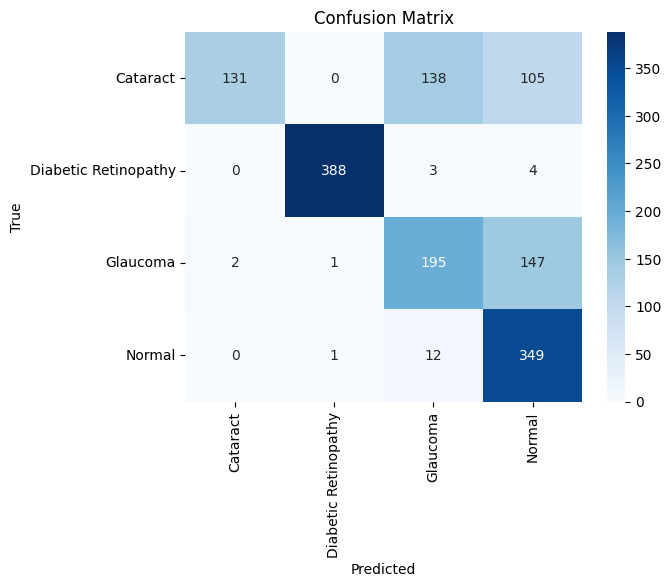

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
